In [56]:
import pandas as pd 
import matplotlib.pyplot as plt
from mplsoccer import Pitch, add_image, FontManager
import requests
import json
from bs4 import BeautifulSoup
from PIL import Image 
from urllib.request import urlopen
from urllib.error import HTTPError
import ScraperFC as sfc

sofascore = sfc.Sofascore()

URL_MATCH = "https://www.sofascore.com/huachipato-cobreloa/jnbsonb#11986410"
#URL_MATCH = "https://www.sofascore.com/metropolitanos-zamora/MzcsFZob#11046611"


### Generar el grafico de ejemplo

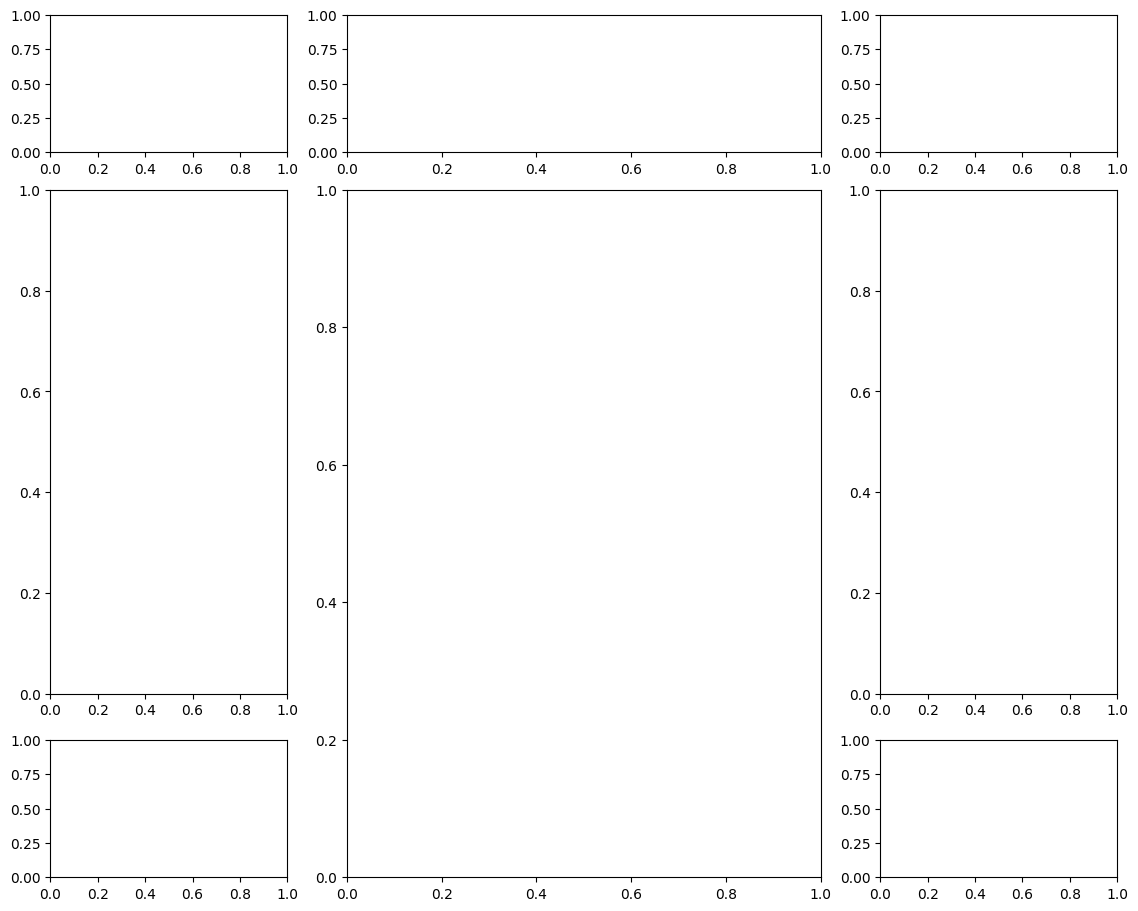

In [57]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=6)
fig.set_facecolor('white')

# escudo local
ax1 = fig.add_subplot(gs[0,0:1])

# escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])

ax3 = fig.add_subplot(gs[0,1:3])

# equipo local
ax6 = fig.add_subplot(gs[1:4,:1])

ax10 = fig.add_subplot(gs[4:,:1])

# info partido
ax7 = fig.add_subplot(gs[1:,1:3])

# equipo visitante
ax8 = fig.add_subplot(gs[1:4,3:4])

ax9 = fig.add_subplot(gs[4:,3:4])



### Agregar la fuente

In [58]:
fuente1 = FontManager("https://github.com/google/fonts/blob/main/ofl/abeezee/ABeeZee-Regular.ttf?raw=true")

### Obtener informacion del partido

In [59]:
partido_sofascore = sofascore.get_match_data(URL_MATCH)
nombre_local, nombre_visit = sofascore.get_team_names(URL_MATCH)
estadisticas_partido = sofascore.get_general_match_stats(URL_MATCH)

df_local, df_visit = sofascore.get_players_match_stats(URL_MATCH)



### Obtener los jugadores destacados en esas metricas

In [60]:
lista_mayores = ['duelWon', 'touches', 'keyPass', 'accuratePass'] # hay ligas que no tienen xG ni xA
nombre_mayores_local = []
valor_mayores_local = []
nombre_mayores_visit = []
valor_mayores_visit = []

# equipo local
for i in range(len(lista_mayores)):
    nombre = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_local.append(nombre)
    valor_mayores_local.append(valor)
    
# equipo visitante
for i in range(len(lista_mayores)):
    nombre = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_visit.append(nombre)
    valor_mayores_visit.append(valor)
    
nombre_mayores_local, valor_mayores_local

(['Isaac Ramírez', 'Luis Vargas', 'Héber García', 'Lucas Federico Trejo'],
 [7.0, 45.0, 3.0, 24.0])

### Obtener imagen del jugador destacado de cada equipo

In [61]:
jugador_destacado_local = df_local[['name', 'rating']].sort_values(by='rating', ascending=False).iloc[0]['name']
jugador_destacado_visit = df_visit[['name', 'rating']].sort_values(by='rating', ascending=False).iloc[0]['name']
id_jug_local = df_local[df_local['name'] == jugador_destacado_local].id.values[0]
id_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit].id.values[0]

try:
  imagen_jug_local = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_local}/image'))
except HTTPError as e:
  print(f'An exception occurred {e}')
  imagen_jug_local = ''

try:
  imagen_jug_visit = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_visit}/image'))
except HTTPError as e:
  print(f'An exception occurred {e}')
  imagen_jug_visit = ''



### Sacar inforamcion de cada jugador

In [62]:
df_jug_local = df_local[df_local['name'] == jugador_destacado_local]
df_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit]

df_jug_local.columns

Index(['name', 'firstName', 'lastName', 'slug', 'shortName', 'position',
       'jerseyNumber', 'userCount', 'id', 'country', 'marketValueCurrency',
       'dateOfBirthTimestamp', 'shirtNumber', 'jerseyNumber', 'position',
       'substitute', 'totalPass', 'accuratePass', 'totalLongBalls',
       'accurateLongBalls', 'aerialWon', 'duelWon', 'totalClearance',
       'goodHighClaim', 'savedShotsFromInsideTheBox', 'saves', 'punches',
       'minutesPlayed', 'touches', 'rating', 'possessionLostCtrl',
       'ratingVersions', 'aerialLost', 'duelLost', 'totalContest',
       'wonContest', 'outfielderBlock', 'totalTackle', 'wasFouled', 'fouls',
       'shotOffTarget', 'blockedScoringAttempt', 'interceptionWon',
       'challengeLost', 'keyPass', 'totalCross', 'dispossessed',
       'onTargetScoringAttempt', 'goals', 'goalAssist', 'accurateCross',
       'bigChanceCreated', 'totalOffside', 'captain', 'team'],
      dtype='object')

### obtener informacion de los equipos

In [63]:
# id equipos
idlocal = partido_sofascore['homeTeam']['id']
idvisit = partido_sofascore['awayTeam']['id']

# escudos de los equipos
imagen1 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idlocal}/image'))
imagen2 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idvisit}/image'))

# goles de los equipos
goleslocal = partido_sofascore['homeScore']['normaltime']
golesvisit = partido_sofascore['awayScore']['normaltime']


### Sacar info de la jornada

In [64]:
torneo = partido_sofascore['season']['name']
fecha = partido_sofascore['roundInfo']['round']

f'{nombre_local} - {nombre_visit}'

'Zamora - Metropolitanos'

### Quitar las lineas de los plots

In [65]:
def sacar_spines(ax):
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Obtener estadísticas de cada equipo por separado

In [76]:
listas_estadisticas_partido = ['Expected goals', 'Ball possession', 'Total shots', 'Shots on target', 'Corner kicks', 'Fouls', 'Yellow cards', 'Red cards', 'Counter attacks', 'Goalkeeper saves']
# si no tiene xG lo quita
listas_estadisticas_partido = [elemento for elemento in listas_estadisticas_partido if elemento != 'Expected goals' or 'Expected goals' in estadisticas_partido['name'].to_list()]
lista_valores_partido_local = []
lista_valores_partido_visit = []

# equipo local
for estadistica in listas_estadisticas_partido:
    if estadistica in estadisticas_partido['name'].values:
        valor = estadisticas_partido[estadisticas_partido['name'] == estadistica]['home'].values[0]
        lista_valores_partido_local.append(valor)
    else:
        lista_valores_partido_local.append(0)
    
for estadistica in listas_estadisticas_partido:
    if estadistica in estadisticas_partido['name'].values:
        valor = estadisticas_partido[estadisticas_partido['name'] == estadistica]['away'].values[0]
        lista_valores_partido_visit.append(valor)
    else:
        lista_valores_partido_visit.append(0) 

['Ball possession',
 'Total shots',
 'Shots on target',
 'Corner kicks',
 'Fouls',
 'Yellow cards',
 'Red cards',
 'Counter attacks',
 'Goalkeeper saves']

### Agregar la informacion al plot

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_4804\3520425451.py:33: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0,.8, f'{int(df_jug_local["rating"])} Nota Sofascore', ha='left', va='center', size=15)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_4804\3520425451.py:35: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0,.7, f'{int(df_jug_local["accuratePass"])}/{int(df_jug_local["totalPass"])} Pases Comp.', ha='left', va='center', size=15)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_4804\3520425451.py:37: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0, .6, f'{int(df_jug_local["goals"])} {"Gol" if int(df_jug_local["goals"]) == 1 else "Goles"}', ha='left', va='center', size=15)
C:

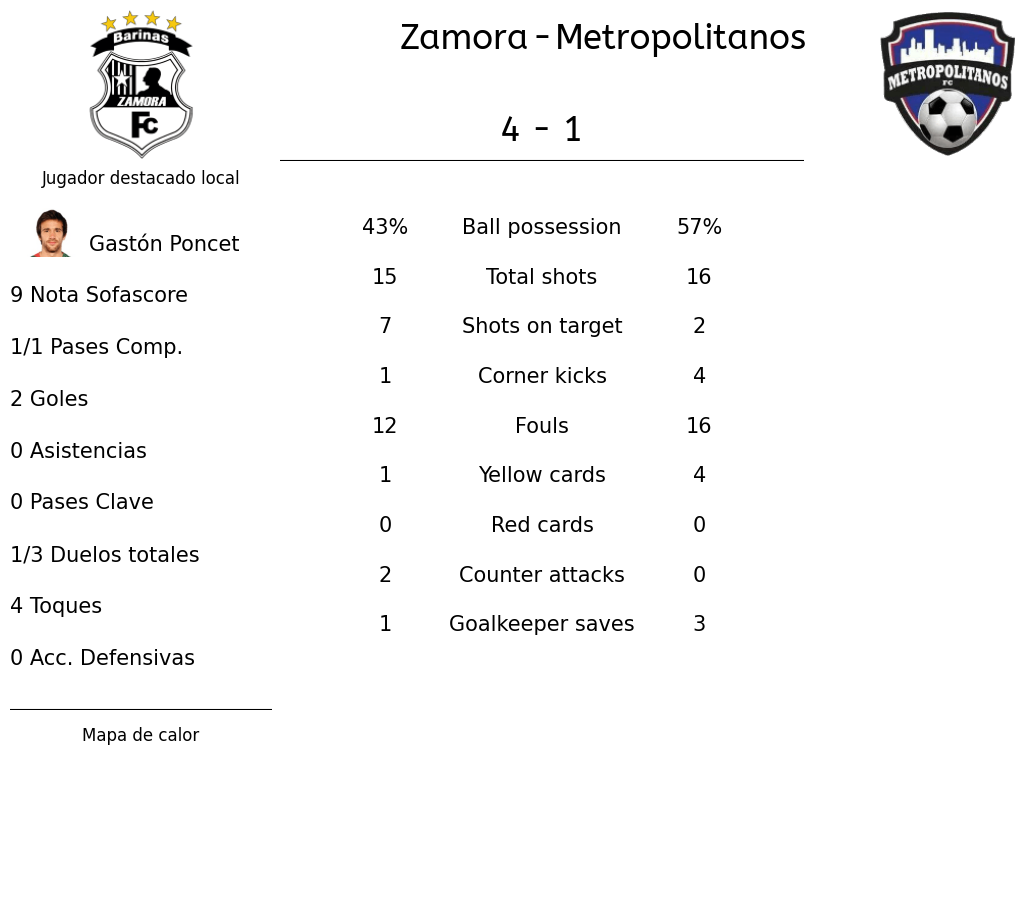

In [82]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=6)
fig.set_facecolor('white')

# Escudo local
ax1 = fig.add_subplot(gs[0,0:1])
ax1.imshow(imagen1)
sacar_spines(ax1)

# Escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])
ax2.imshow(imagen2)
sacar_spines(ax2)

# info del partido
ax3 = fig.add_subplot(gs[0, 1:3])
ax3.text(.475, .8, f'{nombre_local}', ha='right', va='center', fontproperties=fuente1.prop, size=25)
ax3.text(.525, .8, f'{nombre_visit}', ha='left', va='center', fontproperties=fuente1.prop, size=25)
ax3.text(.5, .8, f'-', ha='center', va='center', fontproperties=fuente1.prop, size=25)
ax3.text(.5, .2, f'{goleslocal} - {golesvisit}', ha='center', va='center', fontproperties=fuente1.prop, size=25)
ax3.axhline(0, color='black')
sacar_spines(ax3)

# pasar los valores nulos a 0
df_jug_local = df_jug_local.fillna(0)

# Jugador Destacado local
ax6 = fig.add_subplot(gs[1:4, :1])
ax6.set_title('Jugador destacado local')
ax_image2 = add_image(imagen_jug_local, fig, left=0.00113, bottom=0.72, width=0.055, height=0.055) if imagen_jug_local else None
ax6.text(.3,.90, f'{jugador_destacado_local}', ha='left', va='center', size=15)
#
ax6.text(0,.8, f'{int(df_jug_local["rating"])} Nota Sofascore', ha='left', va='center', size=15)
#
ax6.text(0,.7, f'{int(df_jug_local["accuratePass"])}/{int(df_jug_local["totalPass"])} Pases Comp.', ha='left', va='center', size=15)
#
ax6.text(0, .6, f'{int(df_jug_local["goals"])} {"Gol" if int(df_jug_local["goals"]) == 1 else "Goles"}', ha='left', va='center', size=15)
#
goalsAssist = df_jug_local["goalsAssist"] if 'goalsAssist' in df_jug_local.columns else 0
ax6.text(0,.5, f'{int(goalsAssist)} {"Asistencia" if int(goalsAssist) == 1 else "Asistencias"}', ha='left', va='center', size=15)
#
keyPass = df_jug_local["keyPass"] if 'keyPass' in  df_jug_local.columns else 0
ax6.text(0,.4, f'{int(keyPass)} {"Pase Clave" if int(keyPass == 1) else "Pases Clave"}', ha='left', va='center', size=15)
#
ax6.text(0,.3, f'{int(df_jug_local["duelWon"])}/{int(df_jug_local["duelLost"])+int(df_jug_local["duelWon"])} Duelos totales', ha='left', va='center', size=15)  
#
ax6.text(0, .2, f'{int(df_jug_local["touches"])} Toques', ha='left', va='center', size=15) 
#
ax6.text(0, .1, f'{int(df_jug_local["totalTackle"]+df_jug_local["interceptionWon"]+df_jug_local["totalClearance"])} Acc. Defensivas', ha='left', va='center', size=15) 
ax6.axhline(0, color='black')
sacar_spines(ax6)

ax10 = fig.add_subplot(gs[4:, :1])
ax10.set_title('Mapa de calor')
# agregar heatmap
sacar_spines(ax10)

# estadisticas del partido
ax7 = fig.add_subplot(gs[1:, 1:3])
i = 1.05
for n in range(len(listas_estadisticas_partido)):
    ax7.text(.5, i-.1, listas_estadisticas_partido[n], ha='center', va='center', size=15)
    i-=.07
i = 1.05
for n in range(len(lista_valores_partido_local)):
    ax7.text(.2, i-.1, lista_valores_partido_local[n], ha='center', va='center', size=15)
    i-=.07
i = 1.05
for n in range(len(lista_valores_partido_visit)):
    ax7.text(.8, i-.1, lista_valores_partido_visit[n], ha='center', va='center', size=15)
    i-=.07
sacar_spines(ax7)